In [54]:
# Aux
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import normalize 

# Model stuff
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [55]:
# Local imports
from utils import pipeline
from utils import remove_colls
from utils import load_data
from synth_data import gen_lin_data
from models import fit_model

In [56]:
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
'''
Parameters to control:
-> data set type
-> model type {linear, nonlinear}
  -> if linear:
    -> if: ensemble
        -> disjoint data split
        -> randomly subsampled data (not disjoint)
    -> else: vanilla model
  -> else: nonlinear vanilla model
-> recourse methods
    -> SCFE
    -> GS
    -> CCHVAE (called 'latent' here)
<<<NOTE: THE SCRIPT ITERATES OVER ALL OF THESE>>>
-> attack methods
    -> CFD attack {our suggestion}
    -> CFD LRT {our suggestion}
    -> vanilla loss attack
    -> LRT loss attack {SOTA}
'''

params = {
    'experiment': 'synthetic',                                      # options: {'synthetic', 'realworld'}
    'datasets': ['mnist', 'heloc', 'default', 'housing'],           # options: datasets: {'churn', 'mnist', 'heloc', 'default', 'housing'}
    'methods': ['scfe'],                                            # current options for linear models: {'scfe','cchvae'}; for nonlinear models: {'scfe'}
    'fit_sgd': False,                                               # boolean: whether linear model should be fitted with sgd
    'linear': True,                                                 # boolean: whether linear or nonlinear model should be fitted
    'hidden_layers': [100] * 1,                                     # list with ints: size of hidden layers (for nonlinear model)
    'epochs': 750,                                                  # int: number epochs (for nonlinear model)
    'batch_size': 32,                                               # int: batch size (for nonlinear model)
    'epsd': 1e-5,                                                   # pos real: constant to ensure stable loss evaluations
    'weighting': 'global',                                          # options: {'global', 'local'}: whether global variance or 1/n_shadow_models variance
    'n_shadow_models': 5,                                           # int: number of shadow models
    'frac': 0.75,                                                   # frac: fraction of samples used for resampling scheme within shadow model train pipeline
    'penalty': 'none',                                              # options: {'none', 'l1', 'l2'}: reguralizer for underlying model
    'C': 1000,                                                      # pos real: regularization strength: higher leads less regularized models
    'ensemble': False,                                               # boolean: whether to fit an underlying ensemble model
    'n_ensemble': 250,                                              # int: number of ensemble models
    'frac_ensemble': 0.75,                                          # pos real in [0,1]: fraction of samples used for resampling to train ensemble model
    'disjoint': True,                                               # boolean: Whether disjoint data sets should be used for training private ensemble
    'n_splits': 3,                                                  # int: Number of disjoint ensembles
    'lr_scfe': 0.005,                                               # pos. real in [0,1]:Learning rate for SCFE gradient descent
    'max_iter': 1000,                                               # int: max number of iterations for SCFE gradient descent
    'quantile': 0.97                                                # pos real in [0,1]: quantile to be used for quantile-based thresholds
}

In [58]:
# Parameters to control the synthetic data generating process described in the README.md
synth_gauss = {    
    'n': 240,                              # n_train -> 5000
    'd': [50, 250, 1500, 1800, 3000],      # data dimensions
    'sigma2': 1,                           # data variance
    'frac_important_features': 0.1,        # fraction of relevant features
    'sigma2_eps': 0.01,                    # label noise
    'corr': 0.0,                           # correlation between features
}

In [59]:
def experiment(params, synth_gauss):

    scores = {
        'dists_train_scfe': [],              # DISTANCES
        'dists_test_scfe': [],
        'dists_train_cchvae': [],
        'dists_test_cchvae': [],
        'dists_train_gs': [],
        'dists_test_gs': [],
        'dists_lrt_train_local_scfe': [],
        'dists_lrt_test_local_scfe': [],
        'dists_lrt_train_global_scfe': [],
        'dists_lrt_test_global_scfe': [],
        'dists_lrt_train_local_gs': [],
        'dists_lrt_test_local_gs': [],
        'dists_lrt_train_global_gs': [],
        'dists_lrt_test_global_gs': [],
        'dists_lrt_train_local_cchvae': [],
        'dists_lrt_test_local_cchvae': [],
        'dists_lrt_train_global_cchvae': [],
        'dists_lrt_test_global_cchvae': [],
        'losses_train': [],                  # LOSSES
        'losses_test': [],
        'stable_losses_train': [],
        'stable_losses_test': [],
        'losses_lrt_train_local': [],
        'losses_lrt_test_local': [],
        'losses_lrt_train_global': [],
        'losses_lrt_test_global': []
    }

    if params['experiment'] == 'realworld':
        #####################
        ###   LAOD DATA   ###
        #####################
        
        '''
        Below the data is not only loaded but also cleaned. 
        We remove columns that lead to multicollinearity problems in linear models.
        After the data is loaded and cleaned, we normalize and split the data into 
        three equal folds. The third fold is usually not necessary, but we used it for
        the quantile strategy (not in the paper). To be consistent across all experiments
        we then applied this splitting strategy across all datasets.
        '''
        
        for dataname in params['datasets']:
            print(f'Computing results on: {dataname}')
            # load and clean data
            df, Y = load_data(dataname)
            # standardize data
            scaler = StandardScaler()
            X = df.values.astype(float)
            scaler.fit(X)
            X = scaler.transform(X)
            # normalize data rowwise by ell 2 norm
            X = normalize(X)
            # split data
            X_train, X_t, Y_train, Y_t = train_test_split(X, 
                                                          Y.astype(float), 
                                                          test_size=0.6666667,
                                                          random_state=10)

            # Make sure 1/3 is hold out data
            X_test, X_prime, Y_test, Y_prime = train_test_split(X_t, 
                                                                Y_t,
                                                                test_size=0.5,
                                                                random_state=11)

            ######################
            ###    FIT MODEL   ###
            ######################
            clf = fit_model(X_train, X_test, Y_train, Y_test, params)
            ######################
            ###     SCORES     ###
            ######################
            scores = pipeline(clf, X_train, X_test, X_prime, Y_train, Y_test, Y_prime, scores, params)

    else:
            #####################
            ### GENERATE DATA ###
            #####################
        for i in synth_gauss['d']:
            print(f'Computing for dimension: {i}')
            X, Y = gen_lin_data(d=i, synth_gauss=synth_gauss)
            # split data
            X_train, X_place, Y_train, Y_place = train_test_split(X, 
                                                                  Y, 
                                                                  test_size=0.666667,
                                                                  random_state=10)
            X_test, X_prime, Y_test, Y_prime = train_test_split(X_place, 
                                                                Y_place, 
                                                                test_size=0.5,
                                                                random_state=11)
            ######################
            ###    FIT MODEL   ###
            ######################
            clf = fit_model(X_train, X_test, Y_train, Y_test, params)
            ######################
            ###     SCORES     ###
            ######################
            scores = pipeline(clf, X_train, X_test, X_prime, Y_train, Y_test, Y_prime, scores, params)
    return scores

In [60]:
def compute_curve(train_scores: list, test_scores: list, pos_label=1):
    '''
    Given scores for train and test:
    Ouput: tprs and fprs
    '''    
    y = np.r_[np.ones(np.shape(train_scores)[0]), np.zeros(np.shape(test_scores)[0])]
    fs, ts, thresholds = metrics.roc_curve(y, np.r_[train_scores, test_scores], pos_label=pos_label)
    return ts, fs

In [61]:
def plots(scores_train, scores_test, synth_gauss, params, title, bins_train=100, bins_test=100, label=1):
    '''
    Given scores for train and test:
    Ouput: plots of log scaled AUC curves & distributions of stats
    '''
    plot_type = params['experiment']
    
    if plot_type == 'realworld':
        n_params = params['datasets']
    else:
        n_params = synth_gauss['d']

    fig, axs = plt.subplots(1, 1 + len(n_params), figsize=(21, 3))
    
    # COMPUTE AUC CURVE
    all_tprs = []
    all_fprs = []
    
    for i in range(len(n_params)):
        tprs, fprs = compute_curve(scores_train[i], scores_test[i], label)
        all_tprs.append(tprs)
        all_fprs.append(fprs)
    
    for it, d in enumerate(n_params):
        auc = np.round_(metrics.auc(all_fprs[it], all_tprs[it]), 2)
        if plot_type == 'synthetic':
            lab = str(d)
            axs[0].loglog(all_fprs[it], all_tprs[it], label=f"d={lab} - auc:{auc}")
        else:
            axs[0].loglog(all_fprs[it], all_tprs[it], label=f"{d} - auc:{auc}")
            
    axs[0].plot([0,1], [0,1], label='Random Baseline', linestyle='dotted', color='black')
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_xlim([0.001, 1.01])
    axs[0].set_ylim([0.001, 1.01])
    axs[0].set_title(title)
    axs[0].legend(framealpha=0.25)

    # COMPUTE DISTRIBUTION HISTOGRAMS
    for i in range(len(n_params)):
        if plot_type == 'synthetic':
            dim = n_params[i]
            n_train = scores_train[i].shape[0]
            eta = np.round(n_train / synth_gauss['d'][i], 2)
            print(f'(# train samples: {n_train}) / (dimension: {dim}) = eta: {eta}')
        axs[1+i].hist(scores_train[i], alpha=0.25, label='train', bins=bins_train, density=True)
        axs[1+i].hist(scores_test[i], alpha=0.25, label='test', bins=bins_test, density=True)
        axs[1+i].set_xlabel('Scores')
        axs[1+i].set_yscale('log')
        if plot_type == 'synthetic':
            axs[1+i].set_title(f'$\eta$ = {eta}')
        else:
            axs[1+i].set_title(f'{n_params[i]}')
        axs[1+i].legend()
    
    plt.tight_layout()
    n_shadow = params['n_shadow_models']
    n_ens = params['n_ensemble']
    dataset = params['experiment']
    plt.savefig(f'experiments/{title}_{dataset}_nshadow{n_shadow}_nensemble{n_ens}.jpg')

GENERATE RESULTS FOR: 5 SHADOW MODELS & 1 ENSEMBLE MODELS
Computing for dimension: 50
Number of training samples: 120
scfe
Computing for dimension: 250
Number of training samples: 120
scfe
Computing for dimension: 1500
Number of training samples: 120
scfe
Computing for dimension: 1800
Number of training samples: 120
scfe
Computing for dimension: 3000
Number of training samples: 120
scfe
(# train samples: 79) / (dimension: 50) = eta: 1.58
(# train samples: 79) / (dimension: 250) = eta: 0.32
(# train samples: 79) / (dimension: 1500) = eta: 0.05
(# train samples: 79) / (dimension: 1800) = eta: 0.04
(# train samples: 79) / (dimension: 3000) = eta: 0.03
(# train samples: 79) / (dimension: 50) = eta: 1.58
(# train samples: 79) / (dimension: 250) = eta: 0.32
(# train samples: 79) / (dimension: 1500) = eta: 0.05
(# train samples: 79) / (dimension: 1800) = eta: 0.04
(# train samples: 79) / (dimension: 3000) = eta: 0.03
(# train samples: 79) / (dimension: 50) = eta: 1.58
(# train samples: 79) / 

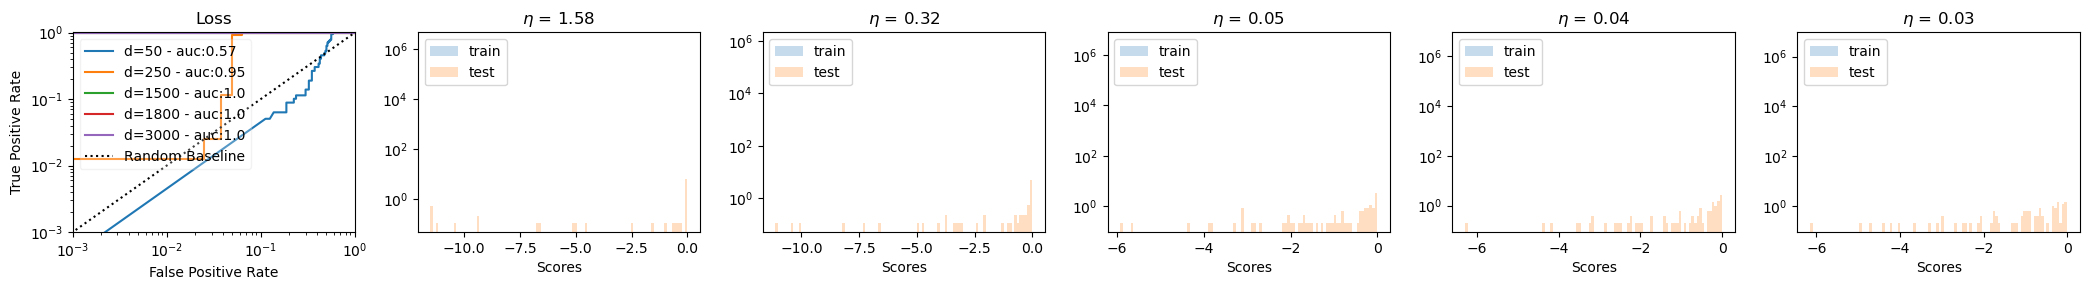

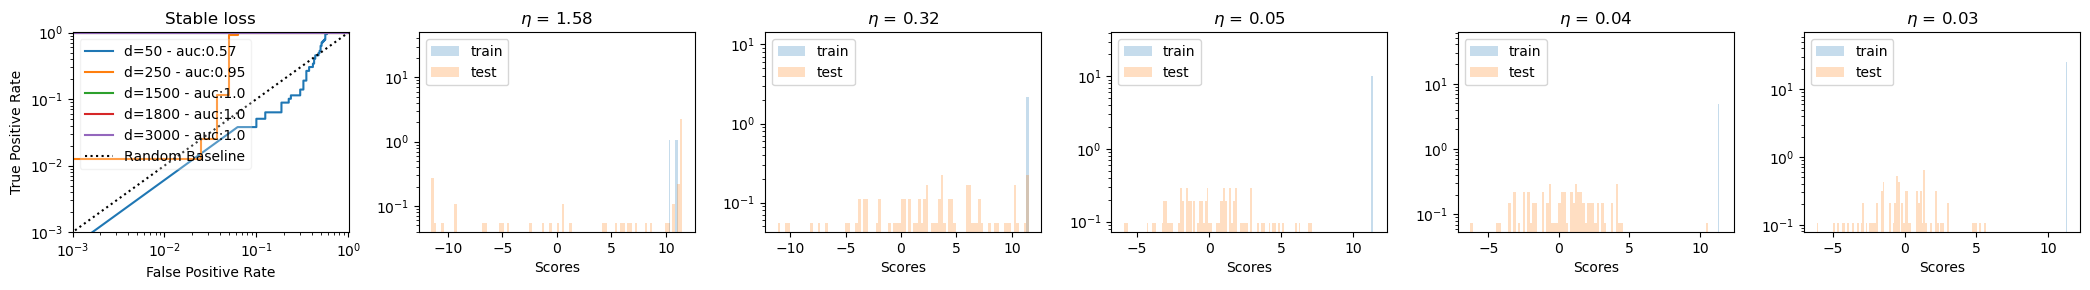

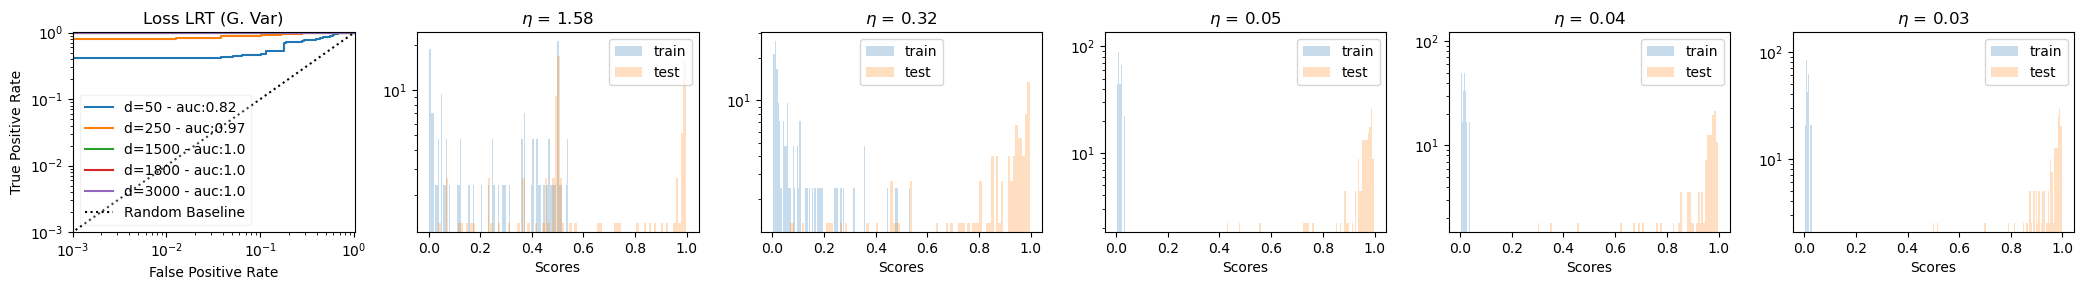

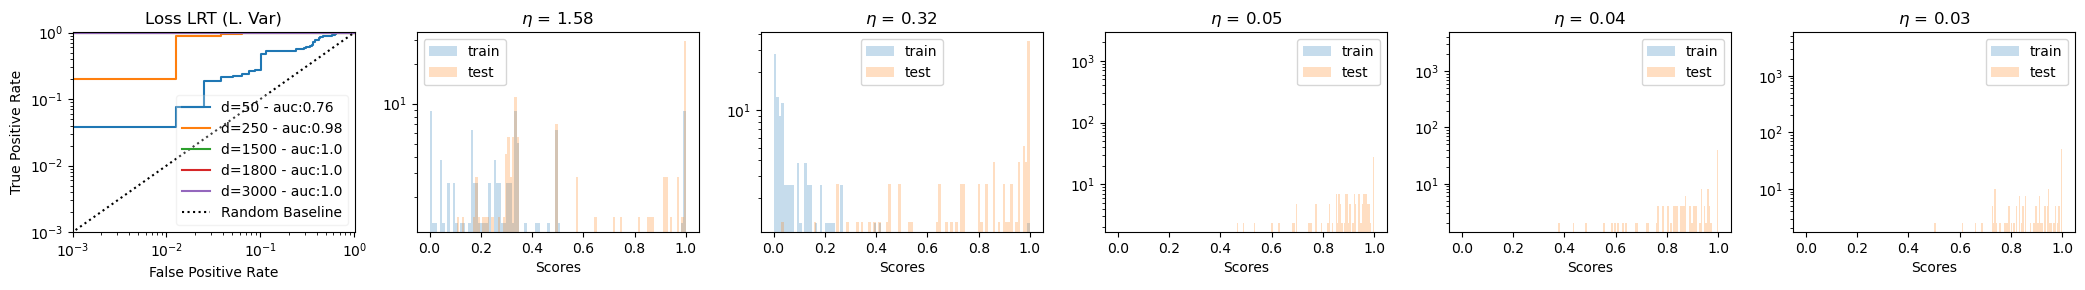

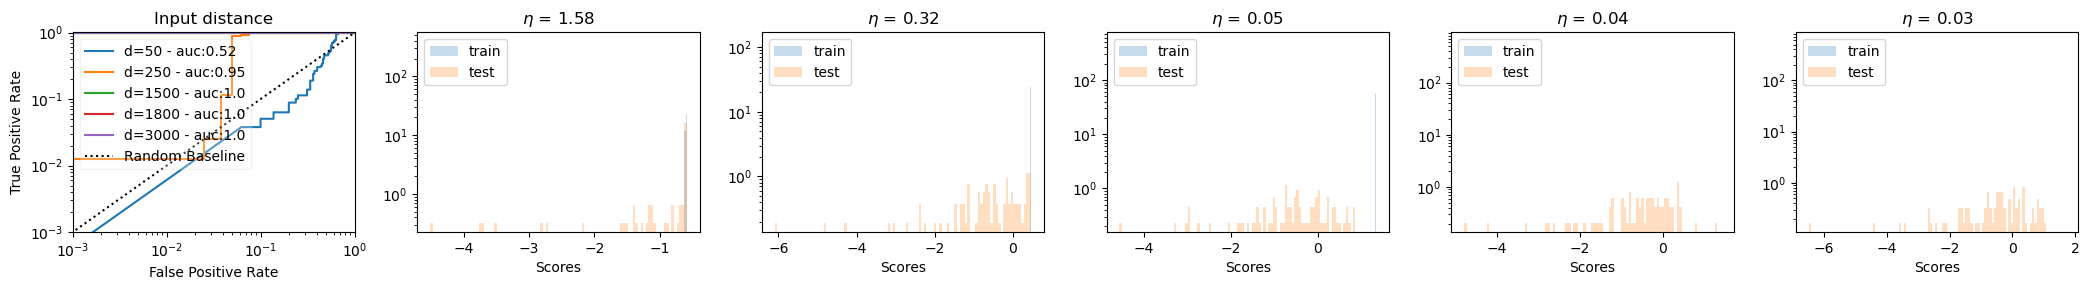

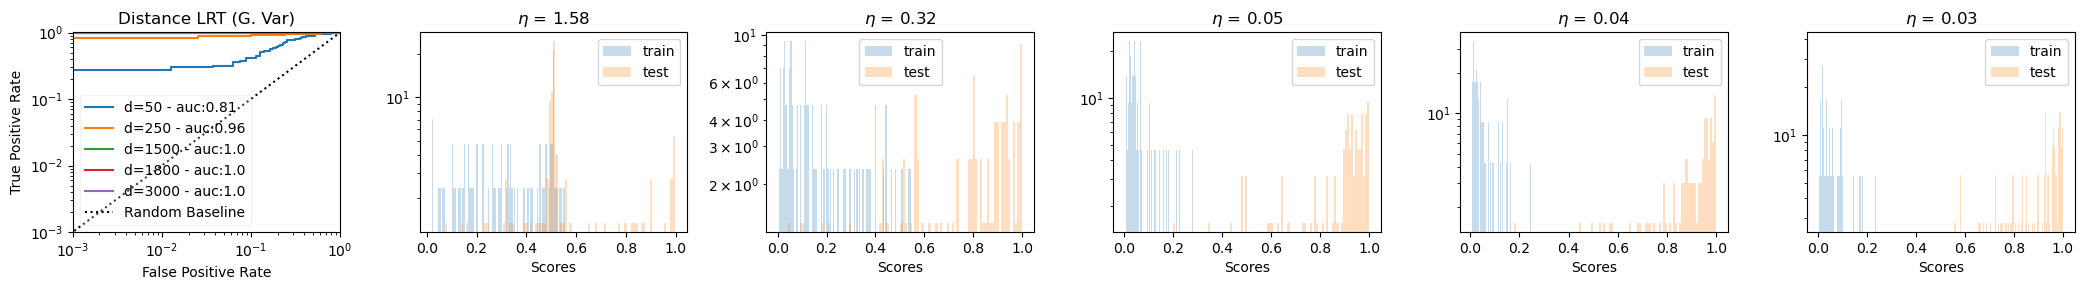

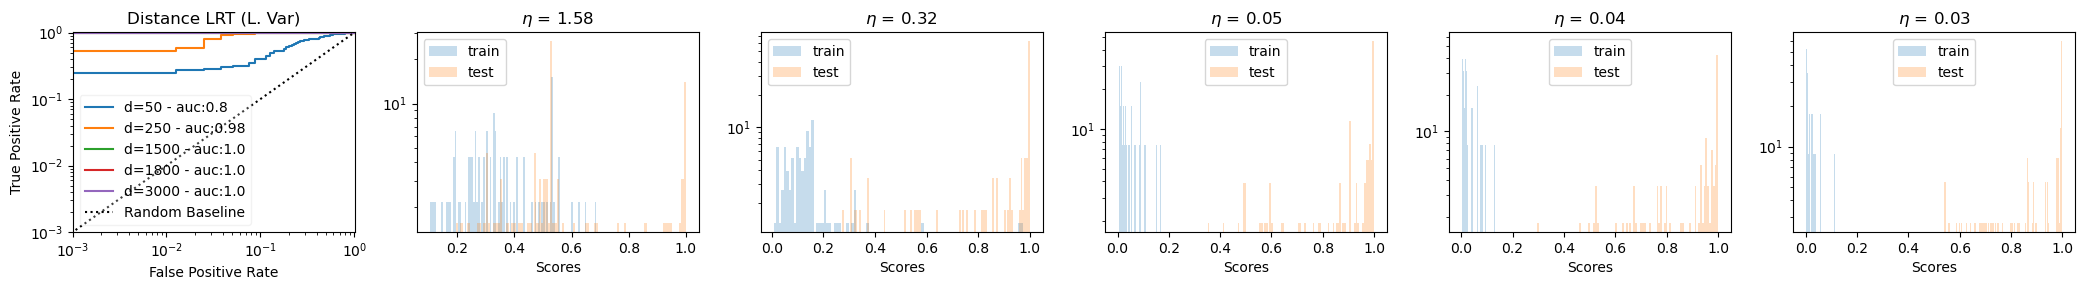

In [62]:
# SETTING -> SHADOW MODELS / ENSEMBLE MODELS 
shadows = [5]
ens = [1]
for m in shadows:
    for n in ens:
        print(f'GENERATE RESULTS FOR: {m} SHADOW MODELS & {n} ENSEMBLE MODELS')
        params['n_shadow_models'] = m
        params['n_splits'] = params['n_ensemble'] = n
        scores = experiment(params, synth_gauss)
        # Generate plots: [log scaled AUC curves & train/test score distributions]
        plots(scores['losses_train'], scores['losses_test'], synth_gauss, params, title='Loss')
        plots(scores['stable_losses_train'], scores['stable_losses_test'], synth_gauss, params, title='Stable loss')
        plots(scores['losses_lrt_train_global'], scores['losses_lrt_test_global'], synth_gauss, params, title='Loss LRT (G. Var)', label=0)
        plots(scores['losses_lrt_train_local'], scores['losses_lrt_test_local'], synth_gauss, params, title='Loss LRT (L. Var)', label=0)        
        plots(scores['dists_train_scfe'], scores['dists_test_scfe'], synth_gauss, params, title='Input distance')
        plots(scores['dists_lrt_train_global_scfe'], scores['dists_lrt_test_global_scfe'], synth_gauss, params, title='Distance LRT (G. Var)', label=0)
        plots(scores['dists_lrt_train_local_scfe'], scores['dists_lrt_test_local_scfe'], synth_gauss, params, title='Distance LRT (L. Var)', label=0)        